# Imports

In [1]:
from kinship_image_data_class import *

# from kinship_image_data_class import KinshipPairs
# from kinship_image_data_class import KinshipDataset

In [2]:
# Common
import pandas as pd
import random
import itertools
import numpy as np
from itertools import product
from tqdm import tqdm

# Files
from pathlib import Path
import os
from PIL import Image

# Machine Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.models import VGG16_Weights, VGG19_Weights, ResNet50_Weights, ResNet152_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Face Net
from facenet_pytorch import InceptionResnetV1, MTCNN

# Other
from typing import List, Tuple, Optional



# EDA

## Data

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior in cuDNN
    torch.backends.cudnn.benchmark = False  # Disables auto-tuning for deterministic behavior

SEED = 42
set_seed(seed=SEED)

In [4]:
# Get the current working directory (cwd)
current_dir = os.getcwd()

# Get the grandparent directory
grandparent_dir = os.path.abspath(os.path.join(current_dir, "..", ".."))

# Paths to data files
train_pairs_dir = os.path.join(grandparent_dir, "Data/families_in_the_wild/train/train-relationship-lists")
train_families_dir = os.path.join(grandparent_dir, "Data/families_in_the_wild/train/train-faces")

test_relationship_lists_dir = os.path.join(grandparent_dir, "Data/families_in_the_wild/test/test-relationship-lists")
test_faces_dir = os.path.join(grandparent_dir, "Data/families_in_the_wild/test/test-faces")
test_relationship_labels_dir = os.path.join(grandparent_dir, "Data/families_in_the_wild/test/test-relationship-labels")

In [5]:
balanced_classes = True
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

dataset = KinshipDataset(train_pairs_dir, train_families_dir,test_faces_dir,test_relationship_lists_dir,test_relationship_labels_dir, train_ratio=train_ratio, validation_ratio=validation_ratio, test_ratio=test_ratio, balanced_classes = balanced_classes)

train_pairs, validation_pairs, test_pairs, original_test_pairs = dataset.train_pairs, dataset.validation_pairs, dataset.test_pairs, dataset.original_test_pairs


train_dataset = KinshipPairs(train_pairs, train_families_dir)
validation_dataset = KinshipPairs(validation_pairs, train_families_dir)
test_dataset = KinshipPairs(test_pairs, train_families_dir)
original_test_dataset = KinshipPairs(original_test_pairs, test_faces_dir)

train_stats = dataset.get_statistics(train_pairs)
validation_stats = dataset.get_statistics(validation_pairs)
test_stats = dataset.get_statistics(test_pairs)


print(" ############ Created Datasets with the following characteristics: ############")
print(f"Balanced classes: {balanced_classes}")
print(f"Train ratio: {train_ratio}")
print(f"Validation ratio: {validation_ratio}")
print(f"Test ratio: {test_ratio}")
print("#### Families ####")
families = set(dataset.train_families_data_dict.keys())
print(f"Number of training families: {int(len(families)*(1-validation_ratio))}")
print(f"Number of validation families: {int(len(families)*validation_ratio)}")
print(f"Number of test families: {int(len(families)*test_ratio)}")
print("#### Set Pairs ####")
print("\nTrain Statistics:", train_stats)
print("\nValidation Statistics:", validation_stats)
print("\nTest Statistics:", test_stats)

 ############ Created Datasets with the following characteristics: ############
Balanced classes: True
Train ratio: 0.8
Validation ratio: 0.1
Test ratio: 0.1
#### Families ####
Number of training families: 565
Number of validation families: 62
Number of test families: 62
#### Set Pairs ####

Train Statistics: {'positive_pairs': 195386, 'negative_pairs': 195386, 'total_pairs': 390772}

Validation Statistics: {'positive_pairs': 61638, 'negative_pairs': 61638, 'total_pairs': 123276}

Test Statistics: {'positive_pairs': 20147, 'negative_pairs': 20147, 'total_pairs': 40294}


## Plots

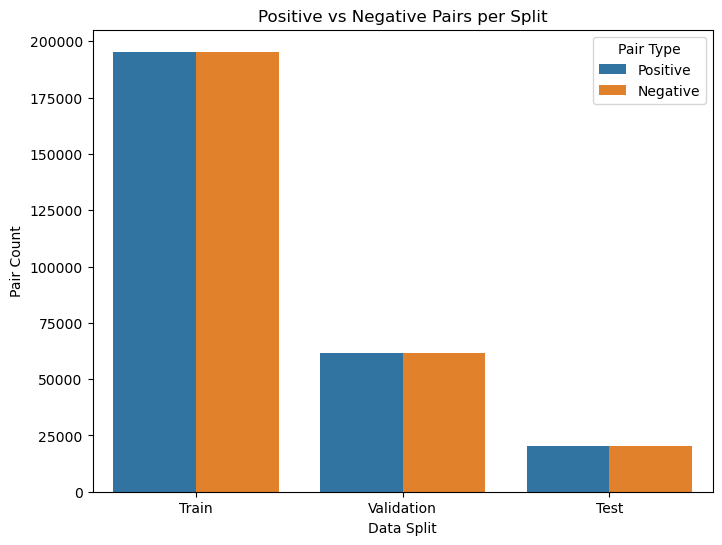

In [6]:
train_pairs = train_stats["total_pairs"]
train_positive_pairs = train_stats["positive_pairs"]
train_negetive_pairs = train_stats["negative_pairs"]

validation_pairs = validation_stats["total_pairs"]
validation_positive_pairs = validation_stats["positive_pairs"]
validation_negetive_pairs = validation_stats["negative_pairs"]

test_pairs = test_stats["total_pairs"]
test_positive_pairs = test_stats["positive_pairs"]
test_negetive_pairs = test_stats["negative_pairs"]




import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for plotting
data = {
    "Split": ["Train", "Train", "Validation", "Validation", "Test", "Test"],
    "Pair Type": ["Positive", "Negative", "Positive", "Negative", "Positive", "Negative"],
    "Count": [
        train_positive_pairs, train_negetive_pairs,
        validation_positive_pairs, validation_negetive_pairs,
        test_positive_pairs, test_negetive_pairs
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x="Split", y="Count", hue="Pair Type", data=df)

# Add title and labels
plt.title("Positive vs Negative Pairs per Split")
plt.xlabel("Data Split")
plt.ylabel("Pair Count")
plt.legend(title="Pair Type")

# Show the plot
plt.show()


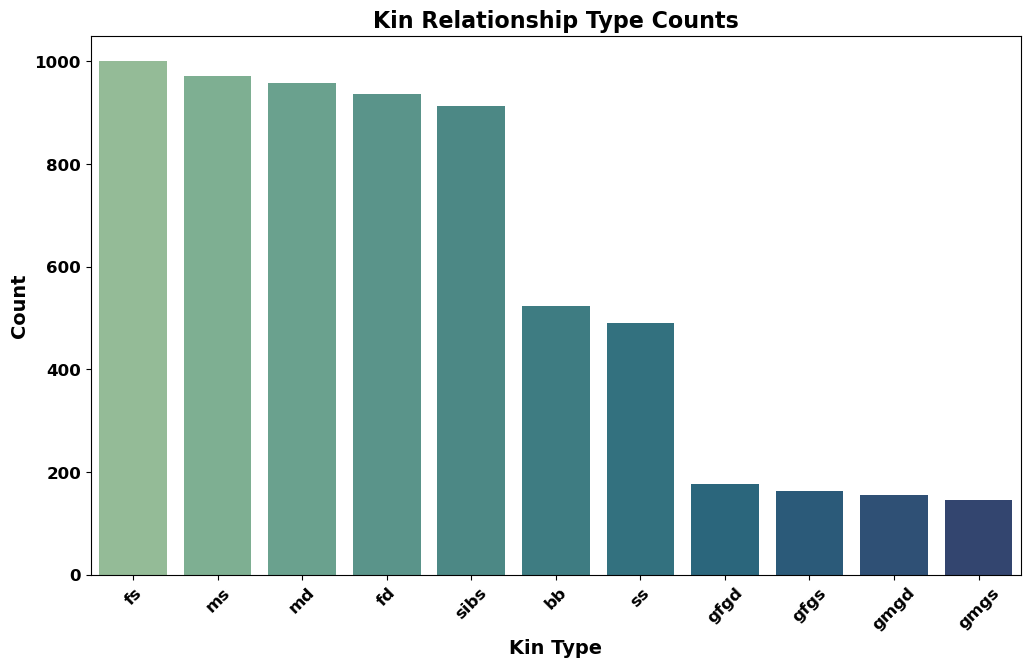

In [7]:
# Count num of each kin relationship pairs.
kin_type_count_dict = {}
for kin_type, df in dataset.train_pair_types.items():
    kin_type_count_dict[kin_type] = len(df)


# Convert dictionary to DataFrame
df = pd.DataFrame(list(kin_type_count_dict.items()), columns=["Kin Type", "Count"])
# Sort by count for better visualization
df = df.sort_values(by="Count", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x="Kin Type", y="Count", data=df, palette="crest")

# Improve readability
plt.title("Kin Relationship Type Counts", fontsize=16, fontweight="bold", color="black")
plt.xlabel("Kin Type", fontsize=14, fontweight="bold")
plt.ylabel("Count", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, fontsize=12, fontweight="bold", color="black")  # Rotate labels
plt.yticks(fontsize=12, fontweight="bold", color="black")

# Show the plot
plt.show()

In [8]:
train_families_set = set(dataset.train_families_data_dict.keys())
validation_families_set = set(dataset.validation_families_data_dict.keys())
test_families_set = set(dataset.test_families_data_dict.keys())

train_dict = {}
validation_dict = {}
test_dict = {}

for pair_type, pair_df in dataset.train_pair_types.items():
    for _, row in pair_df.iterrows():
        family = row['p1'].split("/")[0]
        member_1_dir_path = os.path.join(dataset.train_families_dir, row["p1"])
        member_2_dir_path = os.path.join(dataset.train_families_dir, row["p2"])

        # List all image files in the directories
        member_1_images = [os.path.join(member_1_dir_path, img).split("\\")[-1] for img in os.listdir(member_1_dir_path)]
        member_2_images = [os.path.join(member_2_dir_path, img).split("\\")[-1] for img in os.listdir(member_2_dir_path)]

        # Create all combinations of images between member 1 and member 2
        pairs = [(img1, img2, 1) for img1, img2 in itertools.product(member_1_images, member_2_images)]

        if family in train_families_set:
            if train_dict.get(pair_type, 0) != 0:
                train_dict[pair_type]["count_kin_relationships"] += 1
                train_dict[pair_type]["image_pairs"].extend(pairs)
            else:
                train_dict[pair_type] = {"count_kin_relationships": 1, "image_pairs": pairs}
        elif family in validation_families_set:
            if validation_dict.get(pair_type, 0) != 0:
                validation_dict[pair_type]["count_kin_relationships"] += 1
                validation_dict[pair_type]["image_pairs"].extend(pairs)
            else:
                validation_dict[pair_type] = {"count_kin_relationships": 1, "image_pairs": pairs}
        elif family in test_families_set:
            if test_dict.get(pair_type, 0) != 0:
                test_dict[pair_type]["count_kin_relationships"] += 1
                test_dict[pair_type]["image_pairs"].extend(pairs)
            else:
                test_dict[pair_type] = {"count_kin_relationships": 1, "image_pairs": pairs}

split_data = {
    "train": train_dict,
    "validation": validation_dict,
    "test": test_dict
}

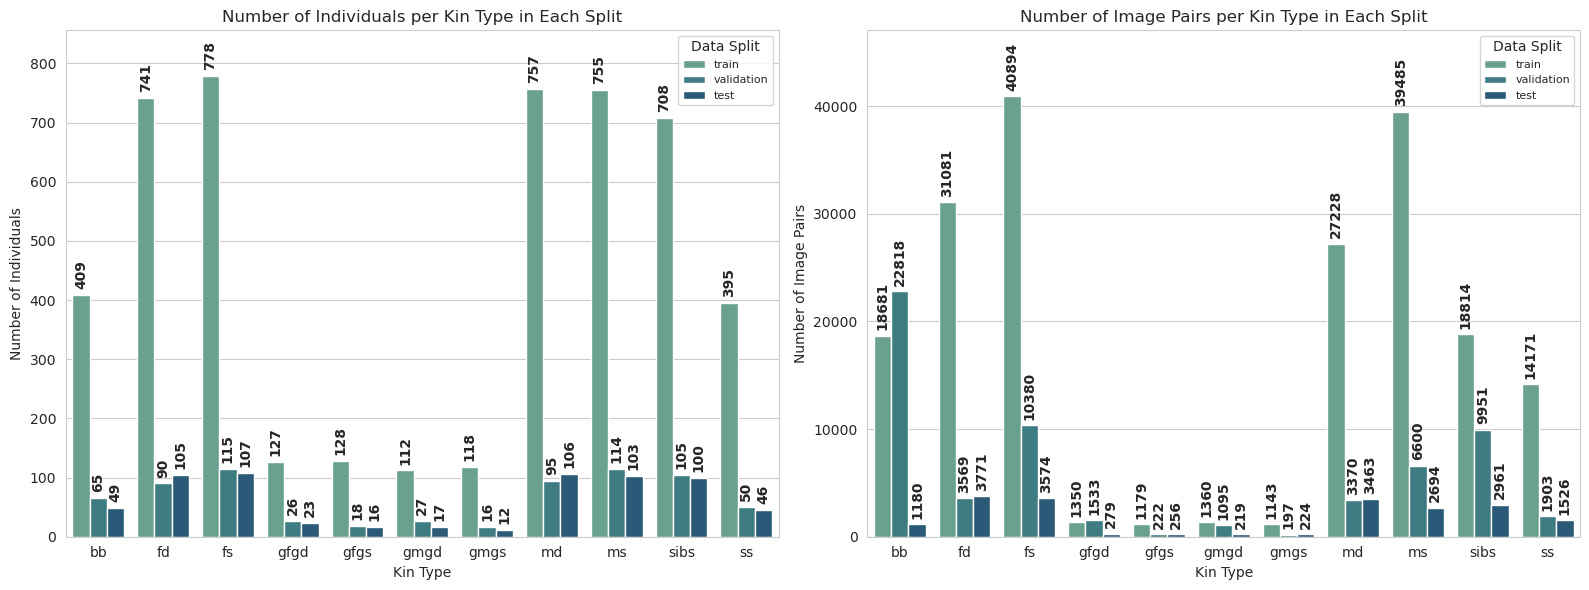

In [9]:
# Prepare data for plotting
data_individuals = []
data_pairs = []

for split, split_dict in split_data.items():
    for kin_type, stats in split_dict.items():
        data_individuals.append({"Kin Type": kin_type, "Split": split, "Count": stats["count_kin_relationships"]})
        data_pairs.append({"Kin Type": kin_type, "Split": split, "Count": len(stats["image_pairs"])})

# Convert to DataFrame for easier plotting
df_individuals = pd.DataFrame(data_individuals)
df_pairs = pd.DataFrame(data_pairs)

# Set style
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))



def add_value_labels(ax,plot_num):
    """ Add labels to the bars with vertical text to avoid overlap. """
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2,  # X-position at center of bar
                height + 10 if plot_num == 0 else height+ 500,  # Y-position slightly above the bar
                f"{int(height)}",  # Convert count to int and display
                ha="center", va="bottom", fontsize=10, fontweight="bold", rotation=90  # Rotate text vertically
            )



# Plot 1: Number of individuals per kin type across splits
sns.barplot(data=df_individuals, x="Kin Type", y="Count", hue="Split", ax=axes[0], palette = "crest")
axes[0].set_title("Number of Individuals per Kin Type in Each Split")
axes[0].set_xlabel("Kin Type")
axes[0].set_ylabel("Number of Individuals")
axes[0].legend(title="Data Split", loc="upper right", fontsize=8)
axes[0].tick_params(axis="x", rotation=0)
add_value_labels(axes[0],0)  # Add value labels

# Plot 2: Number of image pairs per kin type across splits
sns.barplot(data=df_pairs, x="Kin Type", y="Count", hue="Split", ax=axes[1], palette = "crest")
axes[1].set_title("Number of Image Pairs per Kin Type in Each Split")
axes[1].set_xlabel("Kin Type")
axes[1].set_ylabel("Number of Image Pairs")
axes[1].legend(title="Data Split", loc="upper right", fontsize=8)
axes[1].tick_params(axis="x", rotation=0)
add_value_labels(axes[1],1)  # Add value labels

# Set custom y-axis limits (adjust these values as needed)
axes[0].set_ylim(0, df_individuals["Count"].max() * 1.1)  # 10% padding above max value
axes[1].set_ylim(0, df_pairs["Count"].max() * 1.15)  # 10% padding above max value

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

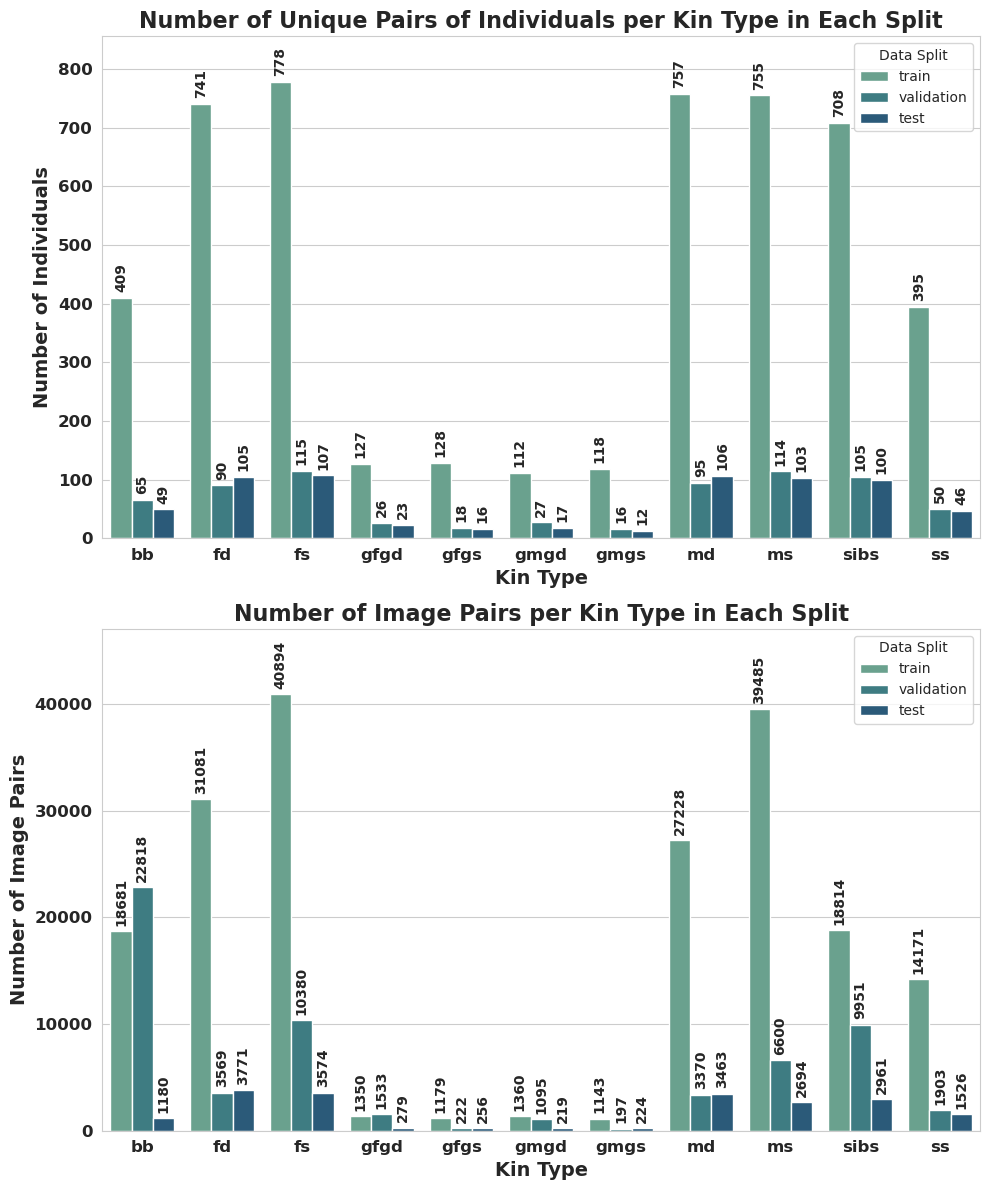

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for plotting
data_individuals = []
data_pairs = []

for split, split_dict in split_data.items():
    for kin_type, stats in split_dict.items():
        data_individuals.append({"Kin Type": kin_type, "Split": split, "Count": stats["count_kin_relationships"]})
        data_pairs.append({"Kin Type": kin_type, "Split": split, "Count": len(stats["image_pairs"])})

# Convert to DataFrame for easier plotting
df_individuals = pd.DataFrame(data_individuals)
df_pairs = pd.DataFrame(data_pairs)

# Set style
sns.set_style("whitegrid")

# Create a figure with two subplots (one below the other)
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows, 1 column

# Function to add value labels to bars
def add_value_labels(ax, plot_num, font_size=10):
    """ Add labels to the bars with vertical text to avoid overlap. """
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2,  # X-position at center of bar
                height + (10 if plot_num == 0 else 500),  # Y-position slightly above the bar
                f"{int(height)}",  # Convert count to int and display
                ha="center", va="bottom", fontsize=font_size, fontweight="bold", rotation=90  # Rotate text vertically
            )

# Function to format axes
def format_axes(ax, x_font_size=12, y_font_size=12, label_font_size=14):
    """ Format the axes labels, ticks, and title with bold text and custom font sizes. """
    ax.set_xlabel(ax.get_xlabel(), fontsize=label_font_size, fontweight="bold")
    ax.set_ylabel(ax.get_ylabel(), fontsize=label_font_size, fontweight="bold")
    ax.tick_params(axis="x", labelsize=x_font_size, width=2)
    ax.tick_params(axis="y", labelsize=y_font_size, width=2)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight("bold")

# Plot 1: Number of individuals per kin type across splits
sns.barplot(data=df_individuals, x="Kin Type", y="Count", hue="Split", ax=axes[0], palette="crest")
axes[0].set_title("Number of Unique Pairs of Individuals per Kin Type in Each Split", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Kin Type")
axes[0].set_ylabel("Number of Individuals")
axes[0].legend(title="Data Split", loc="upper right", fontsize=10)
axes[0].tick_params(axis="x", rotation=0)
add_value_labels(axes[0], 0, font_size=10)  
format_axes(axes[0])

# Plot 2: Number of image pairs per kin type across splits
sns.barplot(data=df_pairs, x="Kin Type", y="Count", hue="Split", ax=axes[1], palette="crest")
axes[1].set_title("Number of Image Pairs per Kin Type in Each Split", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Kin Type")
axes[1].set_ylabel("Number of Image Pairs")
axes[1].legend(title="Data Split", loc="upper right", fontsize=10)
axes[1].tick_params(axis="x", rotation=0)
add_value_labels(axes[1], 1, font_size=10)  
format_axes(axes[1])

# Set custom y-axis limits (adjust these values as needed)
axes[0].set_ylim(0, df_individuals["Count"].max() * 1.1)  
axes[1].set_ylim(0, df_pairs["Count"].max() * 1.15)  

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig("kin_type_distribution_across_splits.png", dpi=300, bbox_inches="tight")
plt.show()

# Result Evaluation

In [35]:
architecture = "SESC"
results_csv_path = f"best model results/test csv results/{architecture}_Test_Results.csv"
results_df = pd.read_csv(results_csv_path)

kin_relationship_list = []
for _, row in results_df.iterrows():
    if row["label"] == 0:
        kin_relationship_list.append(-1)
    else:
        img1_path = row["image 1 full path"]
        img2_path = row["image 2 full path"]
        test_dict = split_data["test"]
        found = False
        for kin_relationship in test_dict:
            image_pair_list = test_dict[kin_relationship]["image_pairs"]
            if (img1_path,img2_path,1) in image_pair_list or (img2_path,img1_path,1) in image_pair_list:
                kin_relationship_list.append(kin_relationship)
                found = True
                break
        if found == False:
            raise Exception("AAAAAAAAAAAAAAA")
results_df["kin relationship"] = kin_relationship_list

## ROC & AUC

Skipping -1 because it has only one class in labels.

AUC Scores (Descending Order):
ss: 0.887
fs: 0.875
ms: 0.873
md: 0.864
Overall: 0.856
fd: 0.854
bb: 0.839
sibs: 0.830
gmgd: 0.823
gfgd: 0.806
gmgs: 0.755
gfgs: 0.726


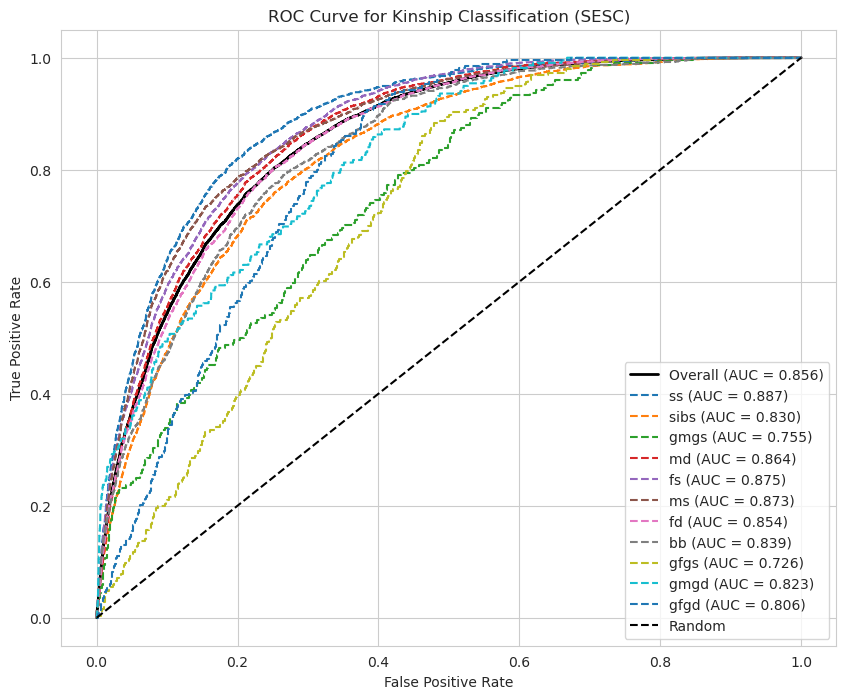

In [41]:
# Ensure seaborn style
sns.set_style("whitegrid")

def plot_roc_curves(results_df):
    plt.figure(figsize=(10, 8))

    auc_scores = {}

    # Overall ROC curve
    fpr, tpr, _ = roc_curve(results_df['label'], results_df['predicted'])
    overall_auc = roc_auc_score(results_df['label'], results_df['predicted'])
    auc_scores['Overall'] = overall_auc
    plt.plot(fpr, tpr, color='black', label=f'Overall (AUC = {overall_auc:.3f})', linewidth=2)

    # Unique relationship types (including -1 for non-kin)
    relationship_types = results_df['kin relationship'].unique()

    for kin_type in relationship_types:
        subset = results_df[(results_df['kin relationship'] == kin_type) | (results_df['kin relationship'] == -1)]

        # Skip if only one class is present (to avoid errors)
        if subset['label'].nunique() < 2:
            print(f"Skipping {kin_type} because it has only one class in labels.")
            continue
        
        fpr, tpr, _ = roc_curve(subset['label'], subset['predicted'])
        auc_score = roc_auc_score(subset['label'], subset['predicted'])
        auc_scores[kin_type] = auc_score
        plt.plot(fpr, tpr, label=f'{kin_type} (AUC = {auc_score:.3f})', linestyle="--")

    # Sort and print AUC scores
    sorted_aucs = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nAUC Scores (Descending Order):")
    for kin, auc in sorted_aucs:
        print(f"{kin}: {auc:.3f}")

    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Kinship Classification ({architecture})')
    plt.legend()
    plt.savefig("SESC_ROC_Curve.png", dpi=300, bbox_inches="tight")
    plt.show()

# Call function with your dataframe
plot_roc_curves(results_df)

## Precision Recall


AP Scores (Descending Order):
Overall: 0.835
fs: 0.548
fd: 0.505
md: 0.499
ms: 0.475
sibs: 0.420
ss: 0.385
bb: 0.255
gmgd: 0.095
gmgs: 0.039
gfgd: 0.038
gfgs: 0.025


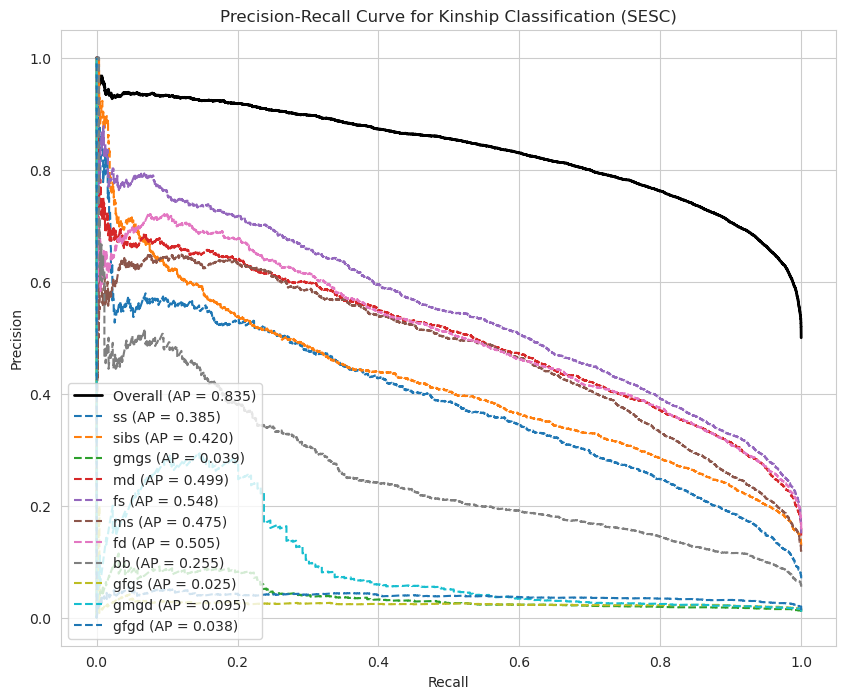

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure seaborn style
sns.set_style("whitegrid")

def plot_precision_recall_curves(results_df):
    plt.figure(figsize=(10, 8))

    ap_scores = {}

    # Overall PR Curve
    precision, recall, _ = precision_recall_curve(results_df['label'], results_df['predicted'])
    overall_ap = average_precision_score(results_df['label'], results_df['predicted'])
    ap_scores['Overall'] = overall_ap
    plt.plot(recall, precision, color="black", label=f'Overall (AP = {overall_ap:.3f})', linewidth=2)

    # Unique relationship types (including -1 for non-kin)
    relationship_types = results_df['kin relationship'].unique()

    for kin_type in relationship_types:
        if kin_type != -1:
            subset = results_df[(results_df['kin relationship'] == kin_type) | (results_df['kin relationship'] == -1)]

            # Skip if there are no positive predictions
            if subset['predicted'].nunique() < 2:
                print(f"Skipping {kin_type} due to constant predictions.")
                continue
            
            precision, recall, _ = precision_recall_curve(subset['label'], subset['predicted'])
            ap_score = average_precision_score(subset['label'], subset['predicted'])
            ap_scores[kin_type] = ap_score
            plt.plot(recall, precision, label=f'{kin_type} (AP = {ap_score:.3f})', linestyle="--")

    # Sort and print AP scores
    sorted_aps = sorted(ap_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nAP Scores (Descending Order):")
    for kin, ap in sorted_aps:
        print(f"{kin}: {ap:.3f}")

    # Labels and title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Kinship Classification ({architecture})')
    plt.legend()
    plt.savefig("SESC_Precision_Recall_Curve.png", dpi=300, bbox_inches="tight")
    plt.show()

# Call function with your dataframe
plot_precision_recall_curves(results_df)

## Rankings


AP Scores (Descending Order):
Overall: 0.835
fs: 0.548
fd: 0.505
md: 0.499
ms: 0.475
sibs: 0.420
ss: 0.385
bb: 0.255
gmgd: 0.095
gmgs: 0.039
gfgd: 0.038
gfgs: 0.025


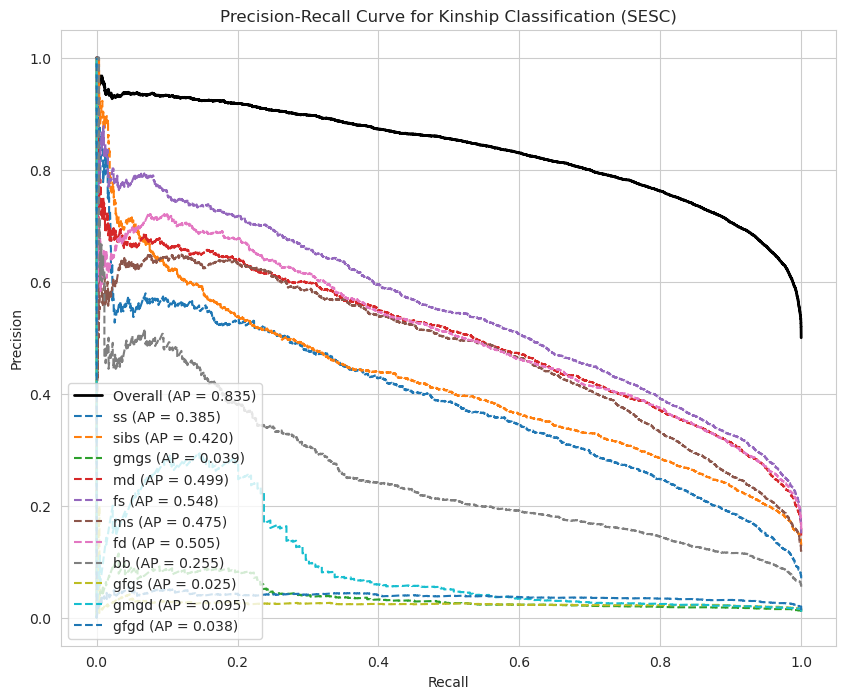

/storage/modules/packages/anaconda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/modules/packages/anaconda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


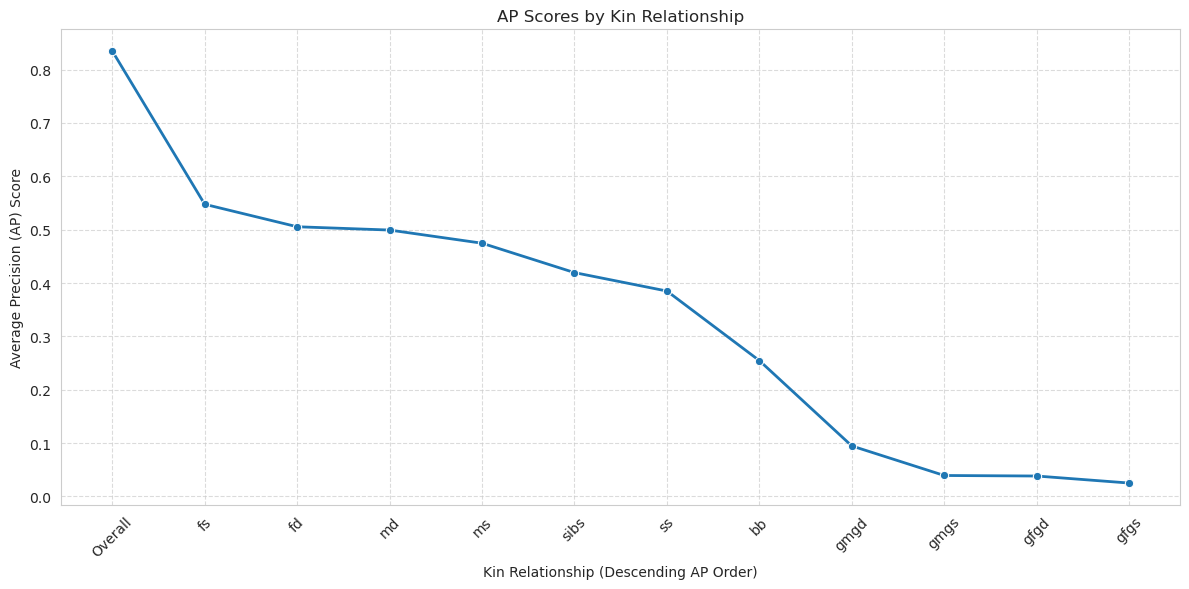

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure seaborn style
sns.set_style("whitegrid")

def plot_precision_recall_curves(results_df):
    plt.figure(figsize=(10, 8))

    ap_scores = {}

    # Overall PR Curve
    precision, recall, _ = precision_recall_curve(results_df['label'], results_df['predicted'])
    overall_ap = average_precision_score(results_df['label'], results_df['predicted'])
    ap_scores['Overall'] = overall_ap
    plt.plot(recall, precision, color="black", label=f'Overall (AP = {overall_ap:.3f})', linewidth=2)

    # Unique relationship types (including -1 for non-kin)
    relationship_types = results_df['kin relationship'].unique()

    for kin_type in relationship_types:
        if kin_type != -1:
            subset = results_df[(results_df['kin relationship'] == kin_type) | (results_df['kin relationship'] == -1)]

            # Skip if there are no positive predictions
            if subset['predicted'].nunique() < 2:
                print(f"Skipping {kin_type} due to constant predictions.")
                continue
            
            precision, recall, _ = precision_recall_curve(subset['label'], subset['predicted'])
            ap_score = average_precision_score(subset['label'], subset['predicted'])
            ap_scores[kin_type] = ap_score
            plt.plot(recall, precision, label=f'{kin_type} (AP = {ap_score:.3f})', linestyle="--")

    # Sort and print AP scores
    sorted_aps = sorted(ap_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nAP Scores (Descending Order):")
    for kin, ap in sorted_aps:
        print(f"{kin}: {ap:.3f}")

    # Labels and title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Kinship Classification ({architecture})')
    plt.legend()
    plt.savefig("SESC_Precision_Recall_Curve.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ------------------ NEW AP SCORE PLOT ------------------
    # Extract kin types and AP scores for the new plot
    kin_types = [str(kin) for kin, _ in sorted_aps]
    ap_values = [ap for _, ap in sorted_aps]

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=kin_types, y=ap_values, marker='o', sort=False, linewidth=2)
    plt.xticks(rotation=45)
    plt.xlabel('Kin Relationship (Descending AP Order)')
    plt.ylabel('Average Precision (AP) Score')
    plt.title('AP Scores by Kin Relationship')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("SESC_AP_Scores_Line_Chart.png", dpi=300, bbox_inches="tight")
    plt.show()

# Call function with your dataframe
plot_precision_recall_curves(results_df)


## Specific Examples






############################# True Positive (Correct Kin) #############################
Pair 6661:
Kin Type: fd
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0205/MID4/P11271_face2.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0205/MID7/P11267_face3.jpg



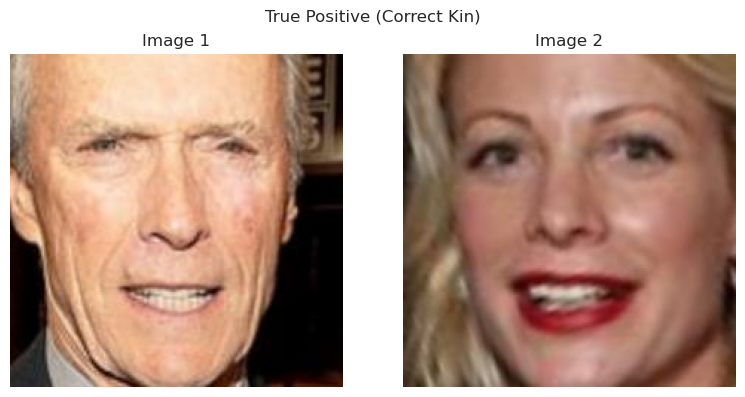

Pair 1058:
Kin Type: sibs
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0583/MID1/P06135_face1.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0583/MID5/P06135_face2.jpg



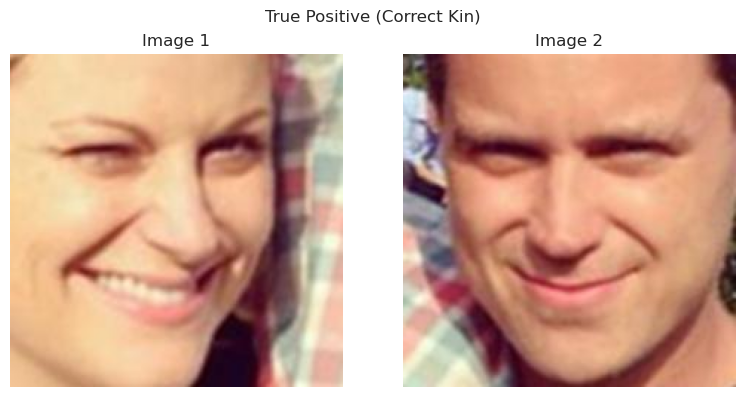






############################# False Positive (Incorrect Kin) #############################
Pair 12086:
Kin Type: -1
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0163/MID6/P01741_face6.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0381/MID1/P04042_face3.jpg



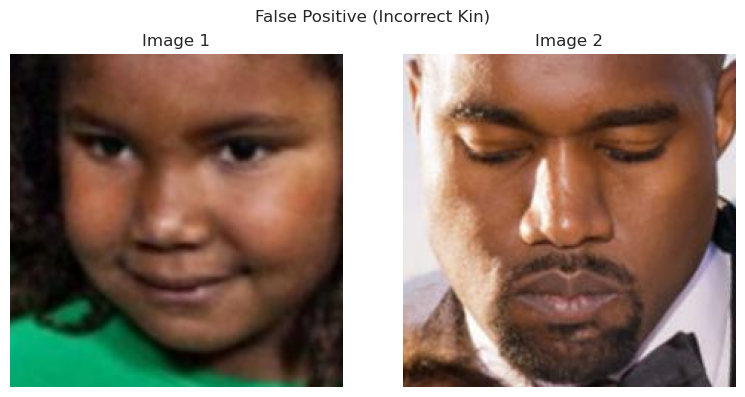

Pair 37121:
Kin Type: -1
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0653/MID1/P06866_face2.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0752/MID10/P07887_face2.jpg



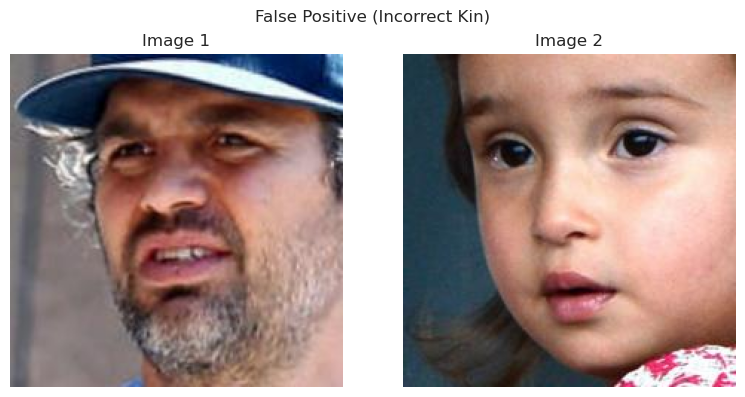






############################# True Negative (Correct Non-Kin) #############################
Pair 17321:
Kin Type: -1
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0007/MID8/P00079_face4.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0968/MID2/P10200_face1.jpg



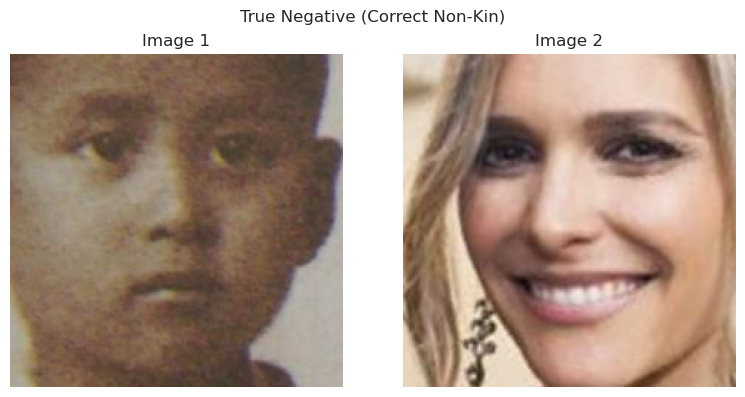

Pair 8749:
Kin Type: -1
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0007/MID2/P11274_face3.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0967/MID2/P10192_face3.jpg



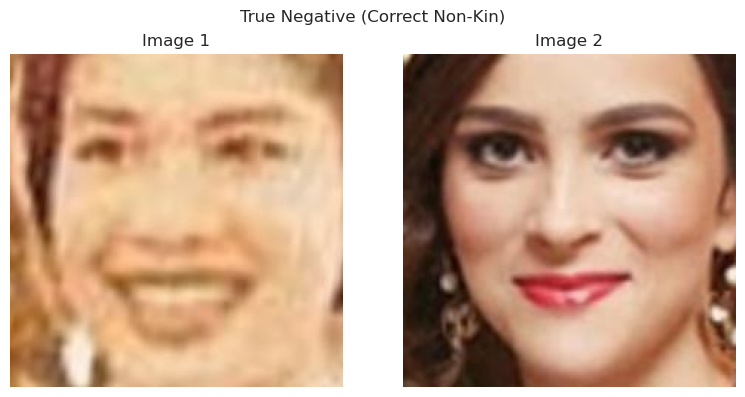






############################# False Negative (Incorrect Non-Kin) #############################
Pair 10518:
Kin Type: gfgd
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0360/MID6/P12314_face2.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0360/MID3/P12303_face4.jpg



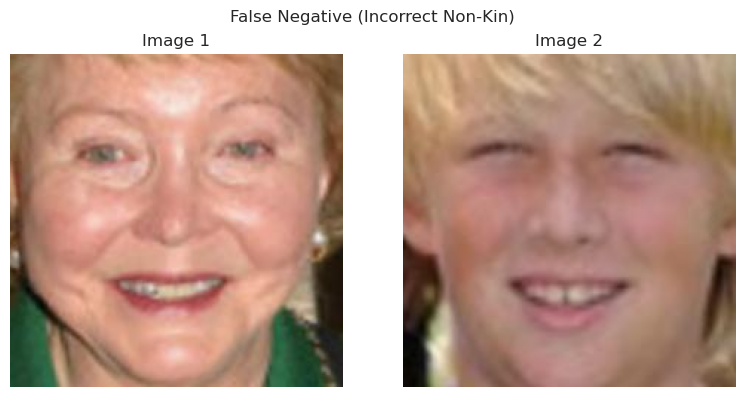

Pair 32854:
Kin Type: fd
Image 1: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0038/MID1/P00397_face1.jpg
Image 2: /sise/home/dzega/projects/kinship_detection_project/Data/families_in_the_wild/train/train-faces/F0038/MID2/P00402_face1.jpg



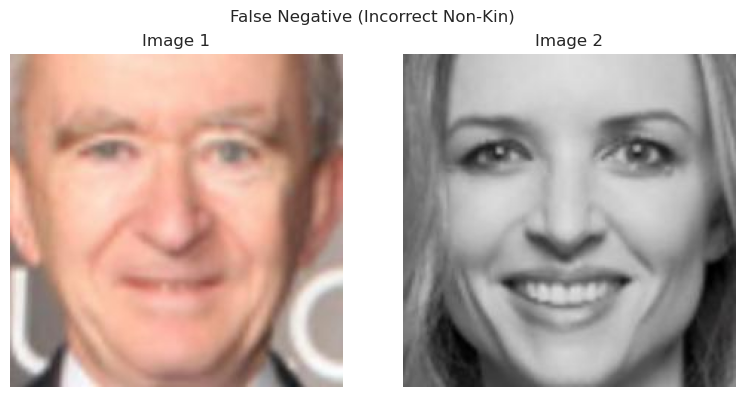

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

def display_image_pairs(results_df, seed=42):
    random.seed(seed)

    # Define cases with conditions
    cases = {
        'True Positive (Correct Kin)': (results_df['label'] == 1) & (results_df['predicted'] > 0.5),
        'False Positive (Incorrect Kin)': (results_df['label'] == 0) & (results_df['predicted'] > 0.5),
        'True Negative (Correct Non-Kin)': (results_df['label'] == 0) & (results_df['predicted'] <= 0.5),
        'False Negative (Incorrect Non-Kin)': (results_df['label'] == 1) & (results_df['predicted'] <= 0.5)
    }

    # Iterate through each case
    for case_name, condition in cases.items():
        subset = results_df[condition]
        
        print(f"\n\n\n\n\n############################# {case_name} #############################")
        
        if len(subset) < 2:
            print(f"Not enough samples for {case_name}. Found only {len(subset)} samples.")
            continue
        
        # Randomly select 2 pairs
        selected_samples = subset.sample(n=2, random_state=seed)

        for idx, row in selected_samples.iterrows():
            img1_path = row['image 1 full path']
            img2_path = row['image 2 full path']
            kin_type = row['kin relationship']
            
            # Print paths
            print(f"Pair {idx+1}:")
            print(f"Kin Type: {kin_type}")
            print(f"Image 1: {img1_path}")
            print(f"Image 2: {img2_path}\n")
            
            # Load images
            img1 = Image.open(img1_path)
            img2 = Image.open(img2_path)

            # Display images side by side
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow(img1)
            axes[0].set_title("Image 1")
            axes[0].axis('off')

            axes[1].imshow(img2)
            axes[1].set_title("Image 2")
            axes[1].axis('off')

            plt.suptitle(case_name)
            plt.tight_layout()
            plt.show()

# Call the function with your DataFrame
display_image_pairs(results_df, seed=1)
